In [1]:
# import all required libriaries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2024-07-02 01:28:02.086555: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Build a CNN network to classify the boat

In [2]:
# !pip install split-folders
# split data into training, validation and test
import splitfolders

input_folder = "/Users/efimova/Documents/AI_Machine_Learning_Bootcamp/5. Deep Learning/final_project/Automating_Port_Operations_dataset"
output = "/Users/efimova/Documents/AI_Machine_Learning_Bootcamp/5. Deep Learning/final_project/Automating_Port_Operations_dataset_split"

splitfolders.ratio(input_folder, output=output, seed=43, ratio=(.64, .16, .2)) # 80% for train and val, and 20% for a test

Copying files: 1162 files [00:01, 666.90 files/s]


In [3]:
batch_size = 32
img_height = 300
img_width = 300

# Load training, validation and test data
train_ds = tf.keras.utils.image_dataset_from_directory(
  f'{output}/train/',
  # validation_split=0.2,
  # subset='training',
  labels='inferred',
  label_mode = 'categorical',
  class_names = ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat'],
  seed = 43,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  f'{output}/val/',
  # validation_split=0.2,
  # subset='validation',
  labels='inferred',
  label_mode = 'categorical',
  class_names = ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat'],
  seed = 43,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  f'{output}/test/',
  # validation_split=0.2,
  # subset='validation',
  labels='inferred',
  label_mode = 'categorical',
  class_names = ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat'],
  seed = 43,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Normalize pixel values to be between 0 and 1
normalization_layer = layers.Rescaling(1./255)
normalized_train_dataset = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_validation_dataset = val_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_test_dataset = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 738 files belonging to 9 classes.
Found 181 files belonging to 9 classes.
Found 243 files belonging to 9 classes.


In [4]:
# create class name variable
class_names = train_ds.class_names

2024-07-02 01:28:39.600699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


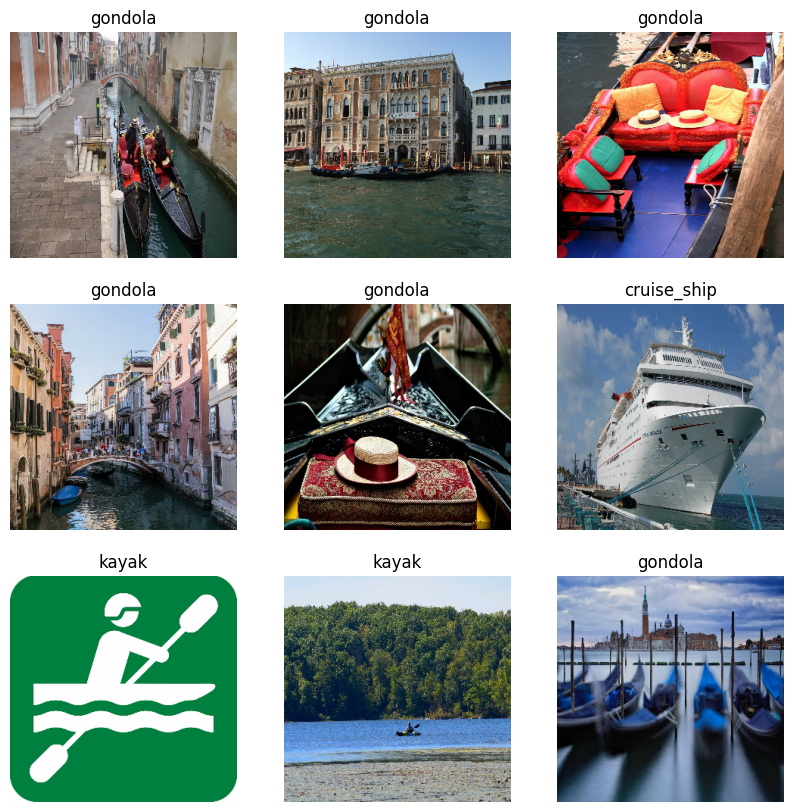

In [5]:
# check images of a train dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i]).numpy()])
        plt.axis("off")

In [6]:
# check a size of an image and label in a normalized training dataset
for image_batch, labels_batch in normalized_train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32, 9)


In [7]:
#initialize a new model based on project requirements

num_classes = len(class_names)

model = Sequential([
  tf.keras.Input((img_width, img_height, 3)),
  #layers.Rescaling(1./255),
  layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu',padding="same"),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,385 (177.29 KB)

 Trainable params: 45,385 (177.29 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# compile the model
model.compile(#optimizer=Adam(learning_rate=0.001), 
              optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy','precision', 'recall'])

In [9]:
# Train the model 
epochs = 20
history = model.fit(
    normalized_train_dataset,
    validation_data=normalized_validation_dataset,
    epochs=epochs
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.2581 - loss: 2.0237 - precision: 0.4329 - recall: 0.0156 - val_accuracy: 0.3425 - val_loss: 1.7696 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.3434 - loss: 1.7779 - precision: 0.2050 - recall: 0.0015 - val_accuracy: 0.3425 - val_loss: 1.7735 - val_precision: 0.5000 - val_recall: 0.0055
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.3309 - loss: 1.8253 - precision: 0.4029 - recall: 0.0136 - val_accuracy: 0.3425 - val_loss: 1.7582 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.3442 - loss: 1.7917 - precision: 0.5073 - recall: 0.0050 - val_accuracy: 0.3425 - val_loss: 1.7356 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.3397 - loss: 1.7629 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy:

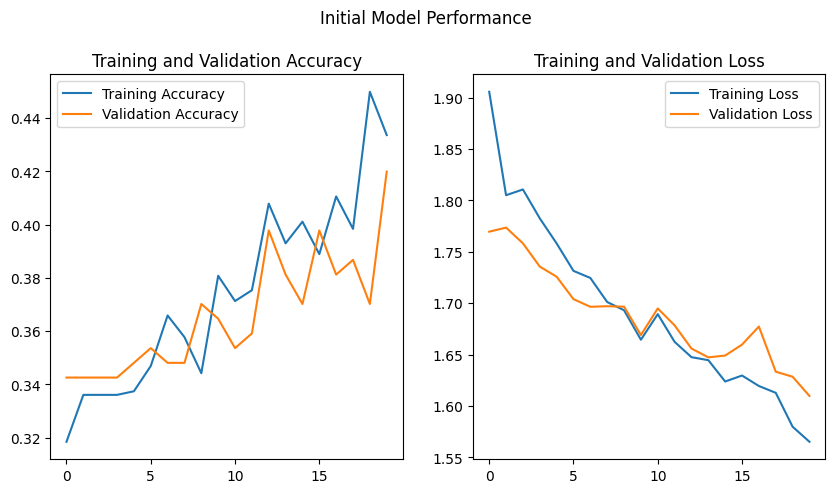

In [10]:
# Plot the training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# making subplots objects
fig.suptitle('Initial Model Performance', y = 1.01)
l1 = ax1.plot(epochs_range, train_acc, label='Training Accuracy')
l2 = ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.legend(loc="best")
ax1.set_title('Training and Validation Accuracy')

l3 = ax2.plot(epochs_range, train_loss, label='Training Loss')
l4 = ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.legend(loc="best")
ax2.set_title('Training and Validation Loss')
plt.show()

In [11]:
# Evaluate the model on test images
score = model.evaluate(normalized_test_dataset)
print(f"Test Accuracy: {score[1]:.2f}")
print(f"Test Loss: {score[0]:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/step - accuracy: 0.3900 - loss: 1.5819 - precision: 0.6799 - recall: 0.1609
Test Accuracy: 0.35
Test Loss: 1.69


In [12]:
# predict a test data
y_pred = model.predict(normalized_test_dataset)
# get y true data
y_true = np.concatenate([y for x, y in normalized_test_dataset], axis=0)
# convert y true data to an integer
y_true_class = np.argmax(y_true, axis=1)

# Convert probabilities to class label numbers
y_pred_class = np.argmax(y_pred, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step


2024-07-02 01:51:55.748123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


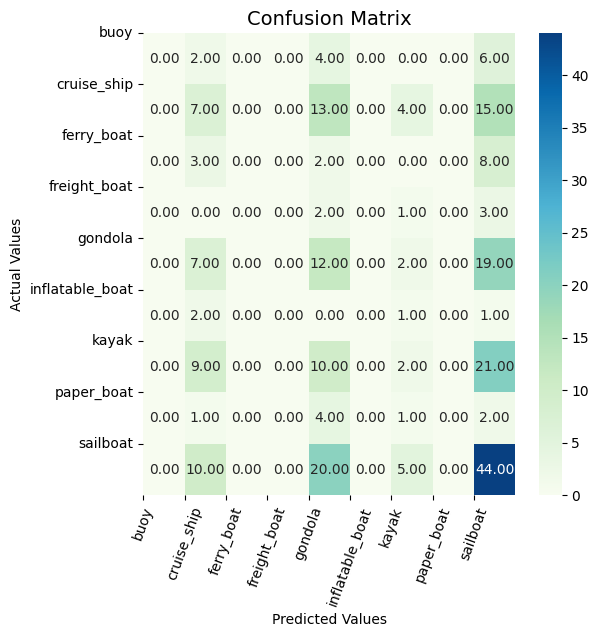

In [13]:
# Plot heatmap of the confusion matrix .
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Vizualize confution matrix
plt.figure(figsize=(6, 6))
plt.title('Confusion Matrix', fontsize=14, y = 1)

sns.heatmap(confusion_matrix(y_true_class,y_pred_class), annot=True, fmt=".2f",cmap="GnBu")

plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
# Set custom ticks on x-axis and y-axis
plt.xticks(list(range(9)), class_names, rotation = 70)
plt.yticks(list(range(9)), class_names, rotation = 0)
plt.show()

In [14]:
# print classification report
from sklearn.metrics import classification_report
import pandas as pd

clr = classification_report(y_true_class, y_pred_class)
    
print("Classification Report:")
print(clr, '\n')

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.17      0.18      0.17        39
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         6
           4       0.18      0.30      0.22        40
           5       0.00      0.00      0.00         4
           6       0.12      0.05      0.07        42
           7       0.00      0.00      0.00         8
           8       0.37      0.56      0.44        79

    accuracy                           0.27       243
   macro avg       0.09      0.12      0.10       243
weighted avg       0.20      0.27      0.22       243
 



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

### Inference from Confusion Metrix and Model Evaluation

1. Model evaluation showed low accuracy for a test data. It does not exeed 40%. Training and validation accuracy is also in low numbers.
2. Losses are hight for all three datasets.
3. During 20 epoches the model did not show significant impovement in an accuracy.
4. Validation and test recalls are not hight. It means a model contains untuned hyperparameters and is not able to learn.
5. Presition and recall for each class is not hight. Only sailsboat types were correcly identified for ~50% of the images.

## Build a lightweight model using MobileNetV2

In [15]:
# split data into training, validation and test

output_lightweight = "/Users/efimova/Documents/AI_Machine_Learning_Bootcamp/5. Deep Learning/final_project/Automating_Port_Operations_dataset_split_Lightweight"

splitfolders.ratio(input_folder, output=output_lightweight, seed=1, ratio=(.49, 0.21, 0.3)) # 70% for train and val and 30% for a test

Copying files: 1162 files [00:01, 710.68 files/s]


In [16]:
# Load training, validation and test data
train_ds_light = tf.keras.utils.image_dataset_from_directory(
  f'{output_lightweight}/train/',
  # validation_split=0.2,
  # subset='training',
  labels='inferred',
  label_mode = 'categorical',
  class_names = ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat'],
  seed = 1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds_light = tf.keras.utils.image_dataset_from_directory(
  f'{output_lightweight}/val/',
  # validation_split=0.2,
  # subset='validation',
  labels='inferred',
  label_mode = 'categorical',
  class_names = ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat'],
  seed = 1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds_light = tf.keras.utils.image_dataset_from_directory(
  f'{output_lightweight}/test/',
  # validation_split=0.2,
  # subset='validation',
  labels='inferred',
  label_mode = 'categorical',
  class_names = ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat'],
  seed = 1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Normalize pixel values to be between 0 and 1
normalized_train_ds_light = train_ds_light.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds_light = val_ds_light.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds_light = test_ds_light.map(lambda x, y: (normalization_layer(x), y))

Found 564 files belonging to 9 classes.
Found 240 files belonging to 9 classes.
Found 358 files belonging to 9 classes.


In [17]:
# import MobileNetV2 Model
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model pre-trained on ImageNet, without the top (classification) layer
base_model = MobileNetV2(input_shape=(img_width, img_height, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Build the model
model_light = Sequential([
    tf.keras.Input((img_width, img_height, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(9, activation='softmax')  # Number of classes
])

# Compile the model
model_light.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy','precision', 'recall'])

model_light.summary()

/var/folders/jz/01qq5g5d2cs6fq77y_2rg6lc0000gp/T/ipykernel_7566/2569236063.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_width, img_height, 3),


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 10, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,513 (10.00 MB)

 Trainable params: 362,761 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

In [19]:
# Train the model for 50 epochs and Early stopping while monitoring validation loss

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_light = model_light.fit(
    normalized_train_ds_light,
    validation_data=normalized_val_ds_light,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.9922 - loss: 0.0343 - precision: 0.9922 - recall: 0.9922 - val_accuracy: 0.8375 - val_loss: 0.5880 - val_precision: 0.8652 - val_recall: 0.8292
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9958 - loss: 0.0216 - precision: 1.0000 - recall: 0.9916 - val_accuracy: 0.8542 - val_loss: 0.5030 - val_precision: 0.8798 - val_recall: 0.8542
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9872 - loss: 0.0321 - precision: 0.9872 - recall: 0.9872 - val_accuracy: 0.8458 - val_loss: 0.4863 - val_precision: 0.8696 - val_recall: 0.8333
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9982 - loss: 0.0203 - precision: 0.9982 - recall: 0.9982 - val_accuracy: 0.8542 - val_loss: 0.5304 - val_precision: 0.8874 - val_recall: 0.8208
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9928 - loss: 0.0245 - precision: 0.9931 - recall: 0.9928 - val_accuracy: 0.8583 - val_loss: 0.5070 - val

In [20]:
# Evaluate Transfered model on test images and print the test loss and accuracy
score_light = model_light.evaluate(normalized_test_ds_light)
print(f"Test Accuracy: {score_light[1]:.2f}")
print(f"Test Loss: {score_light[0]:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8342 - loss: 0.6982 - precision: 0.8589 - recall: 0.8179
Test Accuracy: 0.83
Test Loss: 0.69


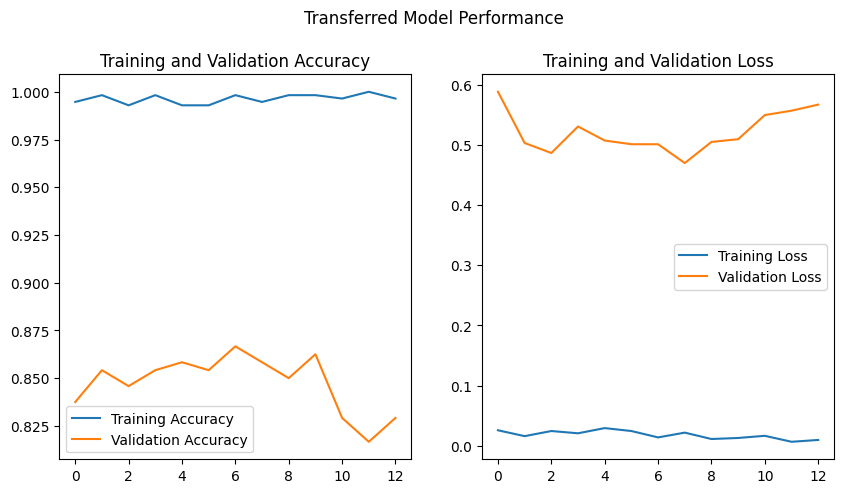

In [22]:
# Plot the training history
train_light_acc = history_light.history['accuracy']
val_light_acc = history_light.history['val_accuracy']
train_light_loss = history_light.history['loss']
val_light_loss = history_light.history['val_loss']

epochs_range_light = history_light.epoch

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# making subplots objects
fig.suptitle('Transferred Model Performance', y = 1.01)
l1 = ax1.plot(epochs_range_light, train_light_acc, label='Training Accuracy')
l2 = ax1.plot(epochs_range_light, val_light_acc, label='Validation Accuracy')
ax1.legend(loc="best")
ax1.set_title('Training and Validation Accuracy')

l3 = ax2.plot(epochs_range_light, train_light_loss, label='Training Loss')
l4 = ax2.plot(epochs_range_light, val_light_loss, label='Validation Loss')
ax2.legend(loc="best")
ax2.set_title('Training and Validation Loss')
plt.show()

### Inference from a lightweight MobileNetV2 model evaluation

1. The Model shows hight performance for all metrics.
2. Accuracy of a training model was low for the first epoch. However, it drastically improved starting from the second epoch.
3. Losses are minimal for a training data and are close to 0.
4. Losses on the validation data are higher, but do not exeed 0.5.
5. Presition and Recall are close to 1 on training and ~0.8 on the validation data.
6. Accuracy for a test data is high and is greater than 80%.
7. Validation accuracy is going down around 11-12 epoch. Early stopping feature hault the training and choose the best weight based on a validation loss.

In [23]:
# Compare the results of both models built in steps 1 and 2 and state your observations
data = [
    ('Metrics Name', 'Initial Model', 'Lightweighted Model'),
    ('Accuracy', round(score[1],2), round(score_light[1] ,2)),
    ('Loss', round(score[0], 2), round(score_light[0],2)),
]
data_df = pd.DataFrame(data[1:],columns = data[0])

In [24]:
print(data_df)

  Metrics Name  Initial Model  Lightweighted Model
0     Accuracy           0.35                 0.83
1         Loss           1.69                 0.69


### Two Models Comparison

1. A model with a transfer from MobileNetV2 model (Model 1) showed significant improvement compare to the initial model (Model 2).
2. Accuracy for a Model 2 is two times greater than a Model 1.
3. Loss of a Model 2 is three times lower than a Model 1.